# Cloud Classification: Data Augmentation
---
Identify the type of cloud in the sky using deep transfer learning
___

## Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Configuration

In [3]:
np.random.seed(42)
DATA = Path("../data/")
CLASSES = ['cirrus', 'cumulus', 'stratus']

## Image Transformations

### Experiments to pick right transformations

In [4]:
def get_ex(): return open_image(DATA/'cirrus'/'00000000.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

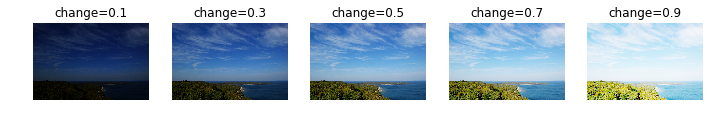

In [5]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for change, ax in zip(np.linspace(0.1,0.9,5), axs):
    brightness(get_ex(), change).show(ax=ax, title=f'change={change:.1f}')

In [6]:
range_lighting = 0.4

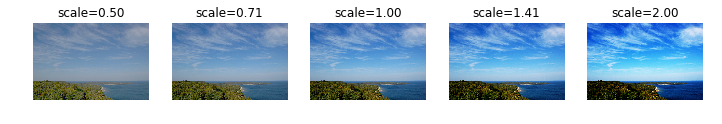

In [7]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for scale, ax in zip(np.exp(np.linspace(log(0.5),log(2),5)), axs):
    contrast(get_ex(), scale).show(ax=ax, title=f'scale={scale:.2f}')

In [8]:
range_contrast = 0.7

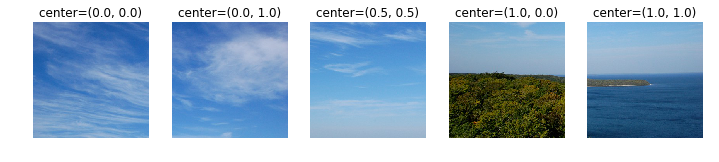

In [9]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for center, ax in zip([[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]], axs):
    crop(get_ex(), 300, *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

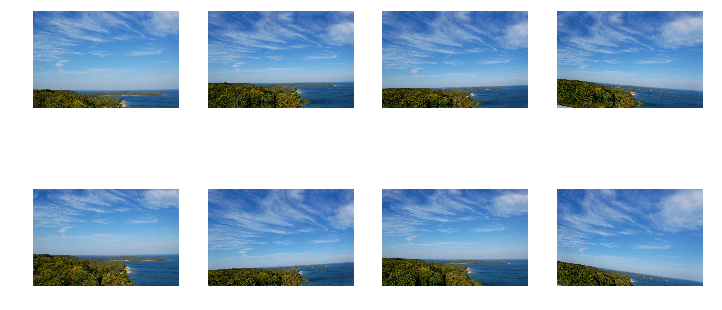

In [10]:
tfm = symmetric_warp(magnitude=(-0.3,0.3))
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm, padding_mode='reflection')
    img.show(ax=ax)

In [11]:
range_warp = 0.3

**NOTE: The defaults are very reasonable**

In [12]:
tfms = get_transforms(do_flip=True, flip_vert=False,max_zoom=1.5,
                      max_lighting=range_lighting, max_warp=range_warp,
                      p_affine=1.0, p_lighting=1.0)

## Load Data

In [13]:
df = pd.read_csv(DATA/'cleaned.csv', header='infer')

In [14]:
df.head()

,name,label
0,cirrus/00000099.jpg,cirrus
1,cirrus/00000069.jpg,cirrus
2,cirrus/00000001.jpg,cirrus
3,cirrus/00000074.jpg,cirrus
4,cirrus/00000022.jpg,cirrus


In [15]:
old_data = ImageDataBunch.from_folder(DATA, train=".", valid_pct=0.2, size=224, bs=10)

In [16]:
data = (ImageList.from_csv(DATA, csv_name='cleaned.csv', header='infer')
           .split_by_rand_pct(valid_pct=0.0)
           .label_from_df(cols='label')
           .transform(tfms, size=224)
           .databunch(bs=10))

In [26]:
len(data.valid_ds),len(old_data.valid_ds) 

(57, 57)

In [18]:
data.valid_dl = old_data.valid_dl

In [19]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (229 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cirrus,cirrus,cirrus,cirrus,cirrus
Path: ../data;

Valid: LabelList (57 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cirrus,cumulus,stratus,cirrus,cumulus
Path: ../data;

Test: None

## Data Visualization

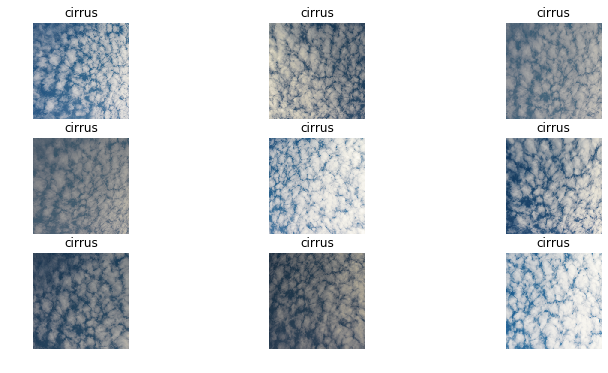

In [20]:
def _plot(r, c, ax):
    x,y = data.train_ds[10]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3)

In [21]:
data.classes, data.c

(['cirrus', 'cumulus', 'stratus'], 3)

In [22]:
len(data.train_ds), len(data.valid_ds)

(229, 57)

In [23]:
data.batch_size

10

## Transfer Leanring: Resnet34 trained on Imagenet 

In [24]:
learner = cnn_learner(data, base_arch=models.resnet34, metrics=[accuracy])

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


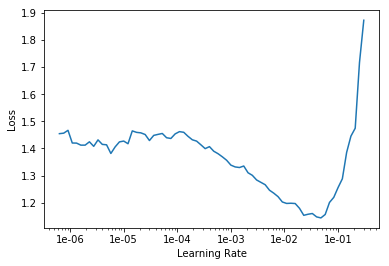

In [27]:
learner.recorder.plot()

In [28]:
lr = 1e-3

In [29]:
learner.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.185954,0.628757,0.736842,00:12
1,0.966214,0.571187,0.807018,00:13
2,0.792067,0.565932,0.807018,00:16


In [30]:
learner.unfreeze()

In [34]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


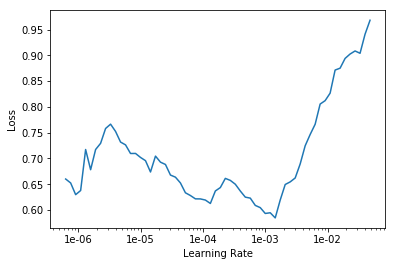

In [35]:
learner.recorder.plot()

In [36]:
new_lr = 1e-5 

In [37]:
learner.fit_one_cycle(4, slice(new_lr, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.680876,0.552676,0.807018,00:13
1,0.652706,0.560213,0.789474,00:12
2,0.614655,0.518782,0.807018,00:12
3,0.614027,0.513262,0.824561,00:12


In [39]:
learner.fit_one_cycle(1, slice(new_lr, lr/10), wd=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.443599,0.544599,0.824561,00:12


In [40]:
learner.save('stage-6')

## Inference

In [41]:
learner = cnn_learner(data, base_arch=models.resnet34, metrics=[accuracy])

In [43]:
learner.load('stage-6');

In [44]:
interp = learner.interpret()

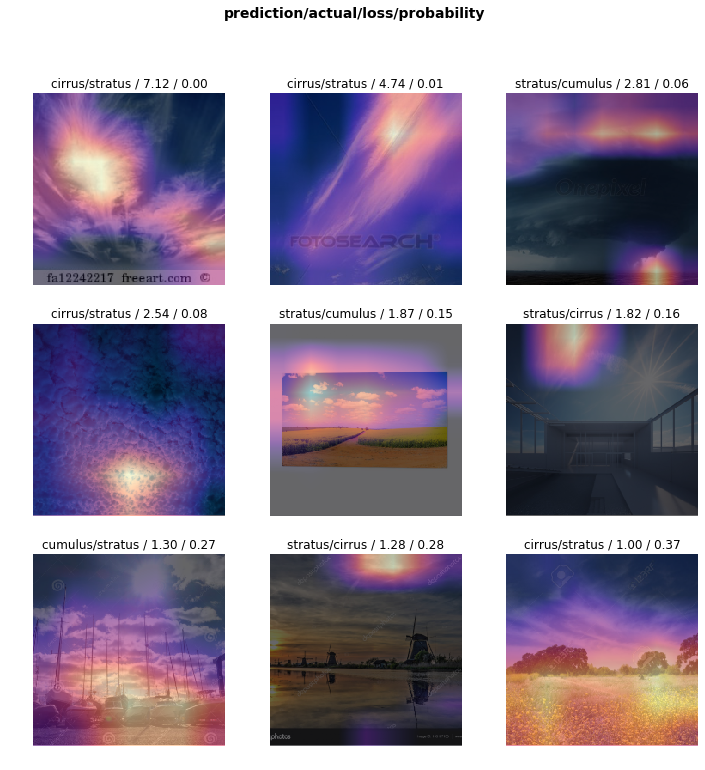

In [49]:
interp.plot_top_losses(9)

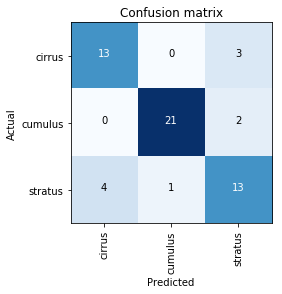

In [50]:
interp.plot_confusion_matrix()

**NOTES**  
Now the problem has been identified to the stratus cloud.
